In [1]:
import matplotlib.pyplot as plt
import os

import pandas as pd
import numpy as np
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn2graph as bnPlot
import pyAgrum.lib.dynamicBN as gdyn
from pyAgrum.lib.image import export

# Diabetes Remission Bayesian Networks

## Create network

In [2]:
bn=gum.BayesNet('Diabetes Remission')
print(bn)

BN{nodes: 0, arcs: 0, domainSize: 1, dim: 0}


In [3]:
G = bn.add(gum.LabelizedVariable('Glycemia','superior to 6.5 ?',2))
I = bn.add(gum.LabelizedVariable('Insulin','Insulin taken ?',2))
O = bn.add(gum.LabelizedVariable('Other_drugs','Other drugs taken ?',2))
R = bn.add(gum.LabelizedVariable('Remission','Remission or not ?',2))
print(bn)

BN{nodes: 4, arcs: 0, domainSize: 16, dim: 8}


In [4]:
for link in [(G, I),(G, O),(O, R),(I, R)]:
    bn.addArc(*link)
print(bn)

BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}


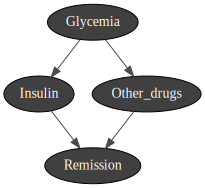

In [5]:
gnb.show(bn)

In [6]:
print(bn)

BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}


In [7]:
print(gum.availableBNExts())
gum.saveBN(bn,"Diabetes_Remission.bif")
with open("Diabetes_Remission.bif","r") as out:
    print(out.read())

bif|dsl|net|bifxml|o3prm|uai
network "Diabetes Remission" {
// written by aGrUM 0.22.8
}

variable Glycemia {
   type discrete[2] {0, 1};
}

variable Insulin {
   type discrete[2] {0, 1};
}

variable Other_drugs {
   type discrete[2] {0, 1};
}

variable Remission {
   type discrete[2] {0, 1};
}

probability (Glycemia) {
   default 0 0;
}
probability (Insulin | Glycemia) {
   (0) 0 0;
   (1) 0 0;
}
probability (Other_drugs | Glycemia) {
   (0) 0 0;
   (1) 0 0;
}
probability (Remission | Other_drugs, Insulin) {
   (0, 0) 0 0;
   (1, 0) 0 0;
   (0, 1) 0 0;
   (1, 1) 0 0;
}




##  Value initialisation

In [8]:
bn.cpt(G).fillWith([0.5,0.5])
bn.cpt('Insulin')[:] = [[0.9, 0.1], [0.1, 0.9]]
bn.cpt('Other_drugs')[:] = [[0.75, 0.25], [0.3, 0.7]]
bn.cpt('Remission')[0, 0, :] = [0.1, 0.9]
bn.cpt('Remission')[{'Insulin': 1, 'Other_drugs': 0}] = [0.6, 0.4]
bn.cpt('Remission')[{'Insulin': 0, 'Other_drugs': 1}] = [0.3, 0.7]
bn.cpt('Remission')[{'Insulin': 1, 'Other_drugs': 1}] = [0.9, 0.1]

In [9]:
bn.cpt(G)

(pyAgrum.Potential<double>@0x55621071a970) 
  Glycemia         |
0        |1        |
---------|---------|
 0.5000  | 0.5000  |

In [10]:
bn.cpt('Insulin')

(pyAgrum.Potential<double>@0x556210a1de60) 
      ||  Insulin          |
Glycem||0        |1        |
------||---------|---------|
0     || 0.9000  | 0.1000  |
1     || 0.1000  | 0.9000  |

In [11]:
bn.cpt('Other_drugs')

(pyAgrum.Potential<double>@0x556210e09270) 
      ||  Other_drugs      |
Glycem||0        |1        |
------||---------|---------|
0     || 0.7500  | 0.2500  |
1     || 0.3000  | 0.7000  |

In [12]:
bn.cpt('Remission')

(pyAgrum.Potential<double>@0x556211014cb0) 
             ||  Remission        |
Other_|Insuli||0        |1        |
------|------||---------|---------|
0     |0     || 0.1000  | 0.9000  |
1     |0     || 0.3000  | 0.7000  |
0     |1     || 0.6000  | 0.4000  |
1     |1     || 0.9000  | 0.1000  |

## Perform inference

In [13]:
ie=gum.LazyPropagation(bn)

In [14]:
ie.posterior('Remission')

(pyAgrum.Potential<double>@0x556210d9b5d0) 
  Remission        |
0        |1        |
---------|---------|
 0.4778  | 0.5223  |

## Inference with evidence

In [15]:
ie.setEvidence({'Glycemia': 1, 'Other_drugs': 1})
ie.makeInference()
ie.posterior("Remission")

(pyAgrum.Potential<double>@0x556210fb0420) 
  Remission        |
0        |1        |
---------|---------|
 0.8400  | 0.1600  |

In [16]:
ie.setEvidence({'Glycemia': 0, 'Insulin': 0})
ie.makeInference()
ie.posterior("Remission")

(pyAgrum.Potential<double>@0x556210c84430) 
  Remission        |
0        |1        |
---------|---------|
 0.1500  | 0.8500  |

It seems that 

if the glycemia level is less than 6.5 and no drugs are taken, the regmission is true with a probability of 0.84.

if the glycemia level is bigger than 6.5 and insulin is prescribed the regmission is true with a probability of 0.15.


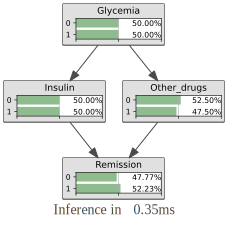

In [17]:
gnb.showInference(bn,evs={})


# 2. Construct Bayesian networks from real data

In [18]:
data_env = pd.read_csv('data/SPLEX_env.txt' , sep=' ')
data_host = pd.read_csv('data/SPLEX_host.txt' , sep=' ')
data_joint = pd.concat([data_env,data_host],axis=1)

In [19]:
def to_csv(data, file):
    l=[]
    for col in data.columns.values:
        bins = np.linspace(min(data[col]), max(data[col]), 5)
        l.append(pd.DataFrame(np.digitize(data[col], bins),columns=[col]))
        
    discr_data = pd.concat(l, join='outer', axis=1)
    discr_data.to_csv(file,index=False)

### Env

In [22]:
to_csv(data_env, "data/discr_data_env.csv")

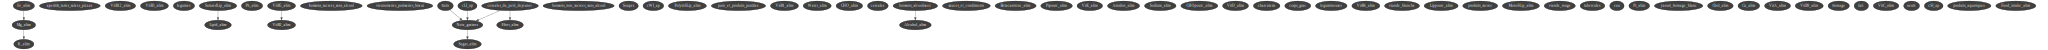

In [108]:
learner=gum.BNLearner("data/discr_data_env.csv")
learner.useLocalSearchWithTabuList()
bn_l = learner.learnBN()
export(bn_l,"data/env_Local_search.pdf")

learner=gum.BNLearner("data/discr_data_env.csv")
learner.useGreedyHillClimbing()
bn_G = learner.learnBN()
export(bn_G,"data/env_Hill_Climbing.pdf")
gnb.showBN(bn_G,size=60000)

### Host

In [25]:
to_csv(data_host, "data/discr_data_host.csv")

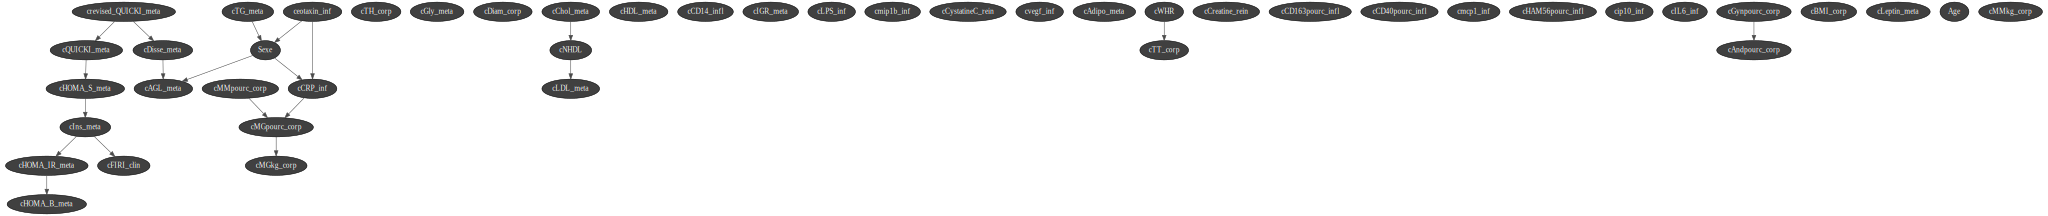

In [109]:
learner=gum.BNLearner("data/discr_data_host.csv")
learner.useLocalSearchWithTabuList()
bn_l = learner.learnBN()
export(bn_l,"data/host_Local_search.pdf")

learner=gum.BNLearner("data/discr_data_host.csv")
learner.useGreedyHillClimbing()
bn_G = learner.learnBN()
export(bn_G,"data/host_Hill_Climbing.pdf")
gnb.showBN(bn_G,size=60000)

### Joint

In [27]:
to_csv(data_host, "data/discr_data_joint.csv")

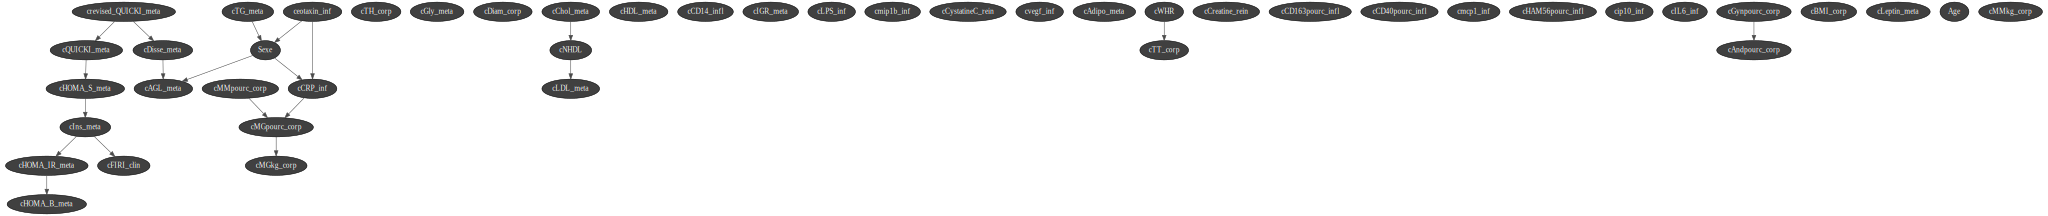

In [110]:
learner=gum.BNLearner("data/discr_data_joint.csv")
learner.useLocalSearchWithTabuList()
bn_l = learner.learnBN()
export(bn_l,"data/joint_Local_search.pdf")

learner=gum.BNLearner("data/discr_data_joint.csv")
learner.useGreedyHillClimbing()
bn_G = learner.learnBN()
export(bn_G,"data/joint_Hill_Climbing.pdf")
gnb.showBN(bn_G,size=60000)

# Dynamic Bayesian networks

In [29]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn

In [ ]:
def to_csv(data, file):
    l=[]
    for col in data.columns.values:
        bins = np.linspace(min(data[col]), max(data[col]), 5)
        l.append(pd.DataFrame(np.digitize(data[col], bins),columns=[col]))
        
    discr_data = pd.concat(l, join='outer', axis=1)
    discr_data.to_csv(file,index=False)

In [30]:
data_dynamic = pd.read_csv('data/dynamic.txt' , sep=' ')

In [65]:
discr_data = []
for data in ['HbA1C', 'Gly', 'Poids', 'Status']:
    t = 3
    heads = [data + str(i) for i in range(t)]
    df = data_dynamic[heads]
    df_min = df.min().min()
    df_max = df.max().max()
    bins = np.linspace(df_min, df_max, 5)
    discr_df = pd.DataFrame(np.digitize(df, bins),columns=heads)
    discr_data.append(discr_df)
discr_data = pd.concat(discr_data, join='outer', axis=1)
discr_data.to_csv('data/discr_dynamic.csv',index=False)

In [51]:
data_dynamic

,HbA1C0,HbA1C1,HbA1C2,Gly0,Gly1,Gly2,Poids0,Poids1,Poids2,Status0,Status1,Status2
0,6.7,5.9,6.1,6.105,4.7,5.0,110.7,67.0,72.0,1,1,3
1,6.0,5.2,5.2,6.327,4.0,4.9,177.0,127.0,143.6,1,1,1
2,6.8,5.9,6.6,7.881,6.0,6.4,133.4,110.0,115.0,1,3,2
3,9.4,7.7,8.4,11.700,9.1,7.9,95.2,80.0,85.1,1,2,2
4,8.0,5.7,5.9,10.700,5.4,5.6,120.0,92.1,84.7,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
170,6.8,5.3,6.1,5.300,6.0,5.3,105.6,73.3,75.0,1,2,3
171,7.6,5.5,7.9,4.500,4.7,10.6,146.7,96.4,88.8,1,2,2
172,6.3,6.1,5.9,5.600,5.4,5.0,102.0,81.4,89.6,1,3,1
173,5.9,6.3,6.3,5.500,5.4,7.7,90.5,73.0,78.0,1,2,2


In [63]:
discr_data

,HbA1C0,HbA1C1,HbA1C2,Gly0,Gly1,Gly2,Poids0,Poids1,Poids2,Status0,Status1,Status2
0,1,1,1,1,1,1,2,1,1,1,1,5
1,1,1,1,1,1,1,4,2,3,1,1,1
2,1,1,1,2,1,1,3,2,2,1,5,3
3,2,2,2,3,2,2,2,1,1,1,3,3
4,2,1,1,2,1,1,2,1,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
170,1,1,1,1,1,1,2,1,1,1,3,5
171,2,1,2,1,1,2,3,2,1,1,3,3
172,1,1,1,1,1,1,2,1,1,1,5,1
173,1,1,1,1,1,2,1,1,1,1,3,3


In [95]:
variables_names = []
for data in ["HbA1C", "Gly", "Poids", "Status"]:
    t = 3
    variables_names += [data + str(i) for i in range(t)]
variables_names

['HbA1C0',
 'HbA1C1',
 'HbA1C2',
 'Gly0',
 'Gly1',
 'Gly2',
 'Poids0',
 'Poids1',
 'Poids2',
 'Status0',
 'Status1',
 'Status2']

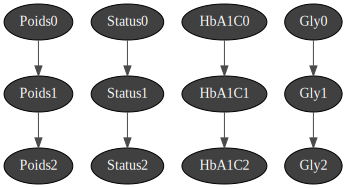

In [96]:
tbn=gum.BayesNet()
variables = [tbn.add(gum.LabelizedVariable(s,s,6)) for s in variables_names]

for link in [(0, 1),(1, 2),(3, 4),(4, 5), (6, 7), (7, 8), (9, 10), (10, 11)]:
    tbn.addArc(*link)
tbn.generateCPTs()
export(tbn,"data/tbn.pdf")
gnb.showBN(tbn)

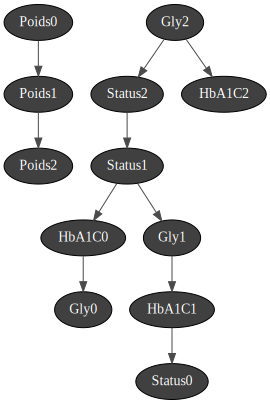

In [102]:
learner=gum.BNLearner("data/discr_dynamic.csv", tbn)
learner.useGreedyHillClimbing()
tbn = learner.learnBN()
export(tbn,"data/tbn.pdf")
gnb.showBN(tbn, size=30)

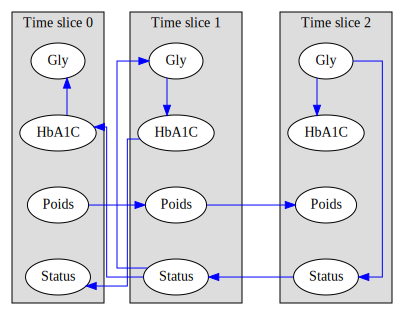

In [100]:
gdyn.showTimeSlices(tbn)

# Reference
http://www-desir.lip6.fr/~phw/aGrUM/docs/last/notebooks/01-tutorial.ipynb.html